<a href="https://colab.research.google.com/github/yvkrishna/fbchatbot/blob/colab-X-ray/Covid_X_RAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

''' covid-chestxray-dataset repo contains x-rays of covid-19 patient. '''
!git clone https://github.com/yvkrishna/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3687, done.
remote: Total 3687 (delta 0), reused 0 (delta 0), pack-reused 3687
Receiving objects: 100% (3687/3687), 715.78 MiB | 37.20 MiB/s, done.
Resolving deltas: 100% (1457/1457), done.
Checking out files: 100% (1152/1152), done.


In [4]:
# importing all the necessary tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import reduce_mean, log
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense
from keras import backend as K

In [5]:
# importing all the necessary packages
import pandas as pd
import numpy as np
import os,csv
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
os.chdir('covid-chestxray-dataset')

In [7]:
metadata = pd.read_csv('metadata.csv')

In [8]:
""" Patient details. """
metadata.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes
0,2,0.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
1,2,3.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
2,2,5.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
3,2,6.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
4,4,0.0,F,52.0,COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN


In [9]:
labels = list(set(metadata.finding))

In [10]:
def get_onehot(outputs,label_set):
  """
    Returns one hot code representation for the label.

    Args :
      outputs : labels of the dataset.
      label_set : contains unique values of the ground truths in the dataset.

    Returns:
      one_hot : one hot representation of the labels
  """
  one_hot = pd.get_dummies(outputs,columns=label_set)

  return one_hot

In [11]:
ground_truths = get_onehot(list(metadata.finding),labels)
data = metadata.drop(columns=["finding"])
data_with_labels = pd.concat([data,ground_truths], join = 'outer', axis = 1)
metadata = data_with_labels
metadata.head()

,patientid,offset,sex,age,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,ARDS,Accelerated Phase Usual Interstitial Pneumonia,Allergic bronchopulmonary aspergillosis,Aspiration pneumonia,Bacterial,COVID-19,"COVID-19, ARDS",Chlamydophila,Chronic eosinophilic pneumonia,Cryptogenic Organizing Pneumonia,Cryptogenic organising pneumonia,Cryptogenic organizing pneumonia,Desquamative Interstitial Pneumonia,E.Coli,Eosinophilic Pneumonia,Eosinophilic pneumonia,Herpes pneumonia,"Herpes pneumonia, ARDS",Influenza,Invasive Aspergillosis,Klebsiella,Legionella,Lipoid,Lobar Pneumonia,Lymphocytic Interstitial Pneumonia,Lymphocytic interstitial pneumonia,MERS-CoV,MRSA,Multilobar Pneumonia,Mycoplasma Bacterial Pneumonia,No Finding,Nocardia,Organizing Pneumonia,Pneumocystis,Pneumonia,Round pneumonia,SARS,Spinal Tuberculosis,Streptococcus,Swine-Origin Influenza A (H1N1) Viral Pneumonia,Tuberculosis,Unknown,Unusual Interstitial Pneumonia,Varicella,todo
0,2,0.0,M,65.0,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,3.0,M,65.0,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,5.0,M,65.0,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,6.0,M,65.0,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0.0,F,52.0,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
train_limit = int(len(metadata)*80/100)
validating_limit = int(len(metadata)*15/100)
testing_limit = int(len(metadata)*5/100)+1

In [13]:
''' 
  spliting the dataframe into two parts for training and validating.
  training : 80% of 936
  validating : 20% of 936
'''
training_data = metadata.iloc[1:train_limit]
validating_data = metadata.iloc[train_limit:len(metadata)-testing_limit]
testing_data = metadata.iloc[train_limit+validating_limit:len(metadata)+1]

In [14]:
print(len(training_data), len(validating_data), len(testing_data))
print(len(training_data)+len(validating_data)+len(testing_data))

743 139 47
929


In [15]:
''' 
  For prediction of covid-19 disease we just need the images and their 
  corresponding labels. 
'''

def dataset_generator(data,x_col,y_col,shuffle=True,batch_size=8,seed=1,target_w = 224,target_h = 224):
  '''
    Returns image name and correspponding label.

    Args :
      data : dataframe. Contains all the information regarding the patients.
      x_col : str. column which holds all the x-ray image names.
      y_col : list. corresponding list of one hot label of the x-ray image.
      shuffle : bool. True to shuffle the images.
      batch_size : int. Number of images to be sent to training at once.
      seed : int. random seed.
      target_w : int. Target width of image.
      target_h : int. Target height of image.

    Returns :
      DataFrameIterator : training_data. 
  '''
  image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
  
  generator = image_generator.flow_from_dataframe(
            dataframe=data,
            directory=list(set(training_data['folder']))[0],
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

  return generator

In [37]:
train_data = dataset_generator(training_data,'filename',labels)
validate_data = dataset_generator(validating_data,'filename',labels)
test_data = dataset_generator(testing_data,'filename',labels)

Found 722 validated image filenames.
Found 139 validated image filenames.
Found 47 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 21 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


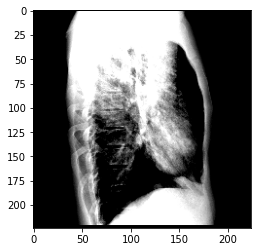

In [17]:
x, y = train_data.__getitem__(0)
plt.imshow(x[0]);

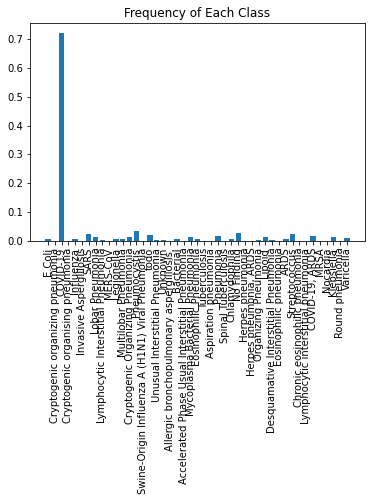

In [18]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_data.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [19]:
def compute_class_freqs(labels):
  '''
    computes the class frequencies.

    Args :
      freq_labels : numpy.ndarray. freq of calsses.
    
    Returns : 
      positive_frequencies : list. A list of positive frequencies.
      negative_frequencies : list. A list of negative_frequencies.
  '''

  N = len(labels)

  positive_frequencies = np.sum(labels , axis=0)/N
  negative_frequencies = np.sum(1-labels , axis=0)/N

  return positive_frequencies,negative_frequencies

In [20]:
pos_freq, neg_freq = compute_class_freqs(train_data.labels)

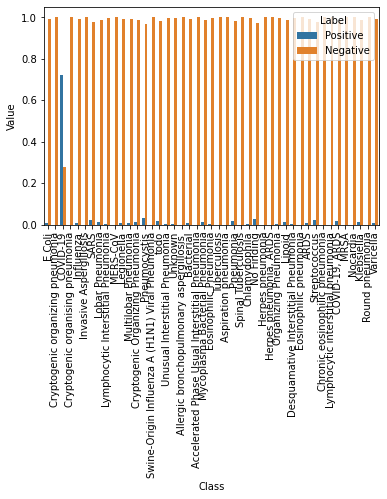

In [21]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_freq})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_freq)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [22]:
'''
  As seen from the above plot, the contributions of positive cases is 
  significantly lower than that of the negative ones. However, we want the 
  contributions to be equal. One way of doing this is by multiplying each 
  example from each class by a class-specific weight factor,  wpos  and  wneg ,
  so that the overall contribution of each class is the same.
'''
pos_weights = neg_freq
neg_weights = pos_freq
pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

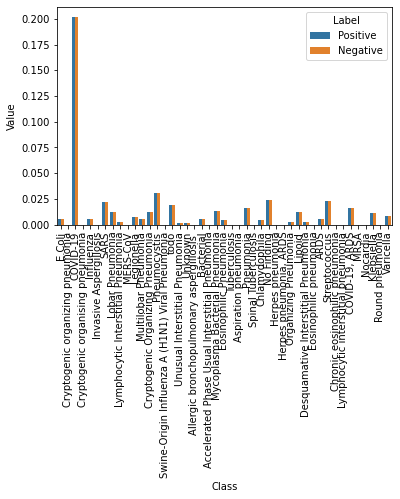

In [23]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [87]:
def weighted_loss(pos_weights,neg_weights, epsilon=1e-7):
  """
    Returns the weighted loss.

    Args : 
      pos_weights : contains positive weights.
      neg_weights : contains negative weights.
      
  Returns : 
    loss_func : function which returns loss
  """

  def loss_func(y_true,y_pred):
    """
      Computes the loss values

      Args : 
        y_true : ground_truths of the xray sampless.
        y_pred : predictions of the xray samples.
      
      Returns :
          loss : computes the loss.
    """
    loss = 0.0
    print(type(y_true[:,0]))
    
    for i in range(len(pos_weights)):
        # for each class, add average weighted loss for that class 
        loss += -1* reduce_mean(tf.convert_to_tensor(pos_weights[i], dtype="float32") * tf.dtypes.cast(y_true[:,i],tf.float32) * log(y_pred[:,i] + epsilon)) \
                        + reduce_mean(tf.convert_to_tensor(neg_weights[i],dtype="float32") * tf.dtypes.cast(1-y_true[:,i],tf.float32) * log(1- y_pred[:,i] + epsilon))
        
    return loss
  
  return loss_func

In [88]:
units = len(labels)

In [89]:
densenet = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_shape=(320, 320, 3),
    pooling=None, classes=units
)

x = densenet.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(units, activation="sigmoid")(x)

model = Model(inputs=densenet.input, outputs=predictions)
model.compile(optimizer="adam", loss=weighted_loss(pos_weights,neg_weights))

In [ ]:
history = model.fit(train_data, 
                              validation_data=validate_data,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

Epoch 1/3
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
 32/100 [========>.....................] - ETA: 6:32 - loss: -4.0521